#### Selection and training best model
#### Metric used are:
#### Accuray, F1 score
#### I will give more enphasis of F1 score because it is a more reliable evaluation metric when working with unbalanced data
#### Targets are: F1>0.95, Accuracy>0.97


In [155]:
#Importing data agumented
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

#For the training of the models i will use the agumented dataset, created in notebook Agumentation
data=pd.read_csv('..\\Dataset\\Dataset_agumented1.csv')
target_acc=0.97
target_f1=0.95



##### Train test split (0.8 train, 0.2 test)

In [156]:

from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(data['Text'].values,data['Class'].values,test_size=0.2,random_state=123,stratify=data['Class'].values)

##### Endocding text data using Tf-If vectorizer (other solution could be word2vec, bert)
##### Tf-idf limitation in this case are handling out-of-vocabolary words and puts more enphasis on the word
##### Word2vec and Bert could be a better solution giving that they enphesis semantic of phrases and not single words

In [157]:
#for this scenerio i will use the default version of the tfidf vectorizer with 

tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train).toarray()

tfidf_test_vectors = tfidf_vectorizer.transform(X_test).toarray()




In [1]:
#saving the embeddings with pickle
import pickle

base_path="..\\..\\models\\"
extension='.pkl'
file_name='embeddings-tfIdf'
Pkl_Filename = base_path+file_name+extension  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tfidf_vectorizer, file)

FileNotFoundError: [Errno 2] No such file or directory: '..\\models\\embeddings-tfIdf.pkl'

##### Handling unbalanced data using SMOTE 
##### NOTE: SMOTE is not ideal for text oversampling but for time reasons i decided to use this rather then other cosutume solutions.


In [80]:

from collections import Counter
smote = SMOTE(random_state=42)
X, Y= smote.fit_resample(tfidf_train_vectors, y_train)



In [17]:
def get_stats_ita_not_ita(X,Y):
    data=[]
    i=0
    for i in range(len(Y)):
        data.append([X[i],Y[i]])

    data_vis=pd.DataFrame(data=data,columns=['Text','Class'])
    italian=len(data_vis[data_vis['Class']==1])
    not_italian=len(data_vis[data_vis['Class']==0])
    total=data_vis.shape[0]
    print('Tot:',total,'Ita:',italian,'Not:',not_italian)
    return (total,italian,not_italian)


In [83]:
print('Before SMOTE')
training_stats=get_stats_ita_not_ita(X_train,y_train)
test_stats=get_stats_ita_not_ita(X_test,y_test)

print('After SMOTE (training)')
training_stats_SMOTE=get_stats_ita_not_ita(X,Y)


Before SMOTE
Tot: 9377 Ita: 1666 Not: 7711
Tot: 2345 Ita: 417 Not: 1928
After SMOTE (training)
Tot: 15422 Ita: 7711 Not: 7711


##### CROSS VALIDATION FUN
##### Type of Cross stratecy: 5-fold cross valdation

In [22]:
# function for cross validation
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean(),
              
              }

##### Visualiziong Cross validation results

In [23]:
#method for plot
import matplotlib.pyplot as plt
import numpy as np
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        
        
        # Set size of plot
        plt.figure(figsize=(8,5))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [27]:
#SAVE MODEL METHOD
#Saving the model
import pickle
def save_model(model,fileName):
    base_path="..\\..\\models\\"
    extension='.pkl'
    Pkl_Filename = base_path+fileName+extension  

    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(model, file)

In [25]:
#LOAD MODEL FUN
def load_model(name):
    with open(name, 'rb') as file:  
        model = pickle.load(file)
    return model

In [26]:
def get_data_stats(X,Y,Y_true):
    data=[]
    for i in range(0,len(X)):
        data.append([X[i],Y[i],Y_true[i]])
    
    out=pd.DataFrame(data=data,columns=['Text','f(x)','true'])
    return out

##### 1. First model: DecisionTreeClassifier (hp: criteria='entropy', randomstate=0 (default version)

In [ ]:
#training the model- Decision tree (hyperparam selecter: randomstae=0, criterion='Entropy')
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                     random_state=0)

In [68]:
#training the model- Decision tree (hyperparam selecter: randomstae=0, criterion='Entropy')
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                     random_state=0)



In [ ]:
decision_tree_result = cross_validation(decision_tree_model, X, Y, 5)

In [ ]:
#Visualizing the traing accuracy and validation accuracy
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            decision_tree_result["Training Accuracy scores"],
            decision_tree_result["Validation Accuracy scores"])

In [ ]:
#Visualizing the traing F1 and validation F1
model_name = "Decision Tree"
plot_result(model_name,
            "F1",
            "F1 scores in 5 fold",
            decision_tree_result["Training F1 scores"],
            decision_tree_result["Validation F1 scores"])

In [69]:
decision_tree_model.fit(tfidf_train_vectors,y_train)
save_model(decision_tree_model,'decision_tree_model')

In [89]:
model=load_model('..\\..\\models\\decision_tree_model.pkl')
y_pred=model.predict(tfidf_test_vectors)



43


In [94]:
data_set_tree=get_data_stats(X_test,y_pred,y_test)
ERRORS=data_set_tree[data_set_tree['f(x)']!=data_set_tree['true']]
print(len(ERRORS))
ERRORS.to_csv('DecisionTree_errors.csv')

43


In [95]:

from sklearn.metrics import f1_score,accuracy_score
acc=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
print('ACCURACY->Target:',target_acc,'Actual',acc)

print('ACCURACY->Target:',target_f1,'Actual',f1)

ACCURACY->Target: 0.97 Actual 0.9816631130063966
ACCURACY->Target: 0.95 Actual 0.9480048367593713


##### 2. Model: Bayesian Classifier

In [42]:
#Training model 2 - Bayesian model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()




KeyboardInterrupt: 

In [ ]:
model_gauss_stas = cross_validation(model, X, Y, 5)

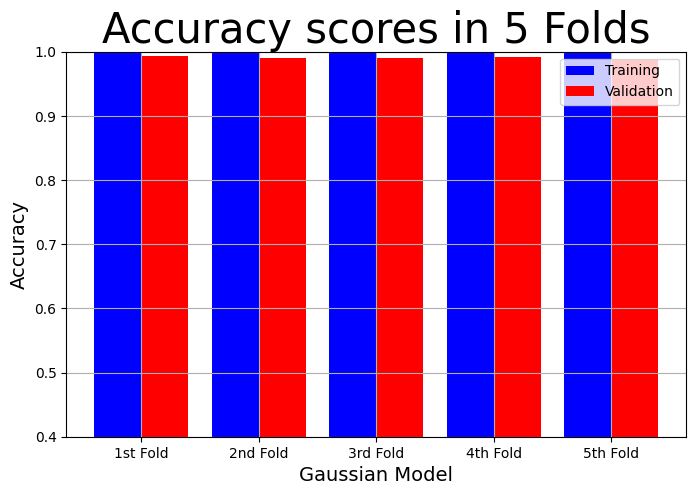

In [33]:
#Visualizing the traing accuracy and validation accuracy
model_name = "Gaussian Model"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            model_gauss_stas["Training Accuracy scores"],
            model_gauss_stas["Validation Accuracy scores"])

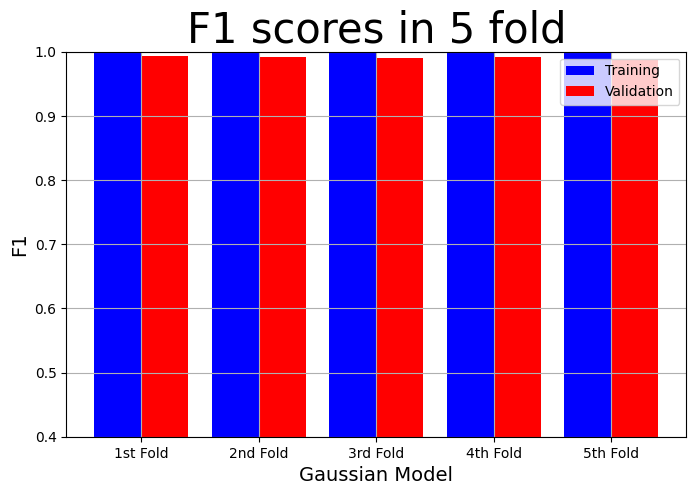

In [34]:
#Visualizing the traing F1 and validation F1
model_name = "Gaussian Model"
plot_result(model_name,
            "F1",
            "F1 scores in 5 fold",
            model_gauss_stas["Training F1 scores"],
            model_gauss_stas["Validation F1 scores"])

In [ ]:
model.fit(X,Y)      #training
save_model(model,'Gaussian_model')

In [171]:
# Load the Model back from file


model=load_model('..\\..\\models\\Gaussian_model.pkl')
y_pred=model.predict(tfidf_test_vectors)









In [167]:
data_set_gaussian=get_data_stats(X_test,y_pred,y_test)
ERRORS=data_set_gaussian[data_set_gaussian['f(x)']!=data_set_gaussian['true']]
Not_ERRORS=data_set_gaussian[data_set_gaussian['f(x)']==data_set_gaussian['true']]


ERRORS.to_csv('Gaussian_errors.csv')
Not_ERRORS.to_csv('Gaussian_correct.csv')


In [100]:
#SCORES

from sklearn.metrics import f1_score,accuracy_score
acc=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
print('ACCURACY->Target:',target_acc,'Actual',acc)

print('ACCURACY->Target:',target_f1,'Actual',f1)

ACCURACY->Target: 0.97 Actual 0.9829424307036247
ACCURACY->Target: 0.95 Actual 0.9539170506912442


### MOdel selecter: Bayesian classifier
### Fast and better f1 score

#### Analytics of error text

In [144]:
def analyze_sing_error(word, vocabolary):
        single_word_string=""
        entry=vocabolary[vocabolary['Word']==word]
        total_count=entry['Total_count'].values
        ita_count=entry['Count_ita'].values
        other_count=entry['Count_other'].values
        single_word_string='Word: '+str(word)+' Total_count: '+str(total_count)+ ' Ita_count: '+str(ita_count)+ ' Other_count: '+str(other_count)
        return single_word_string


In [145]:
def analyze_error(word, words_vocabolary):
    single_entry_string=""
    single_entry_string="Phrase: "+word+"\n"
    phrase_words=word.split(' ')
    for w in phrase_words:
        single_entry_string+=analyze_sing_error(w,words_vocabolary)
    return single_entry_string
        
    
    
    
    

In [154]:
#we analyze the errors made by the model and try to figure out why these errors where made
#we use the words.csv file created in the profiling notepad and the Gaussian_errors.csv 
errors=pd.read_csv('Gaussian_errors.csv')
correct=pd.read_csv('Gaussian_correct.csv')
words=pd.read_csv('..\\Dataset\\words.csv')
words=words.drop(['Unnamed: 0'],axis=1)



error_words=errors['Text'].to_list()

string_errors=''
for i in error_words:
    string_errors+=analyze_error(i,words)+'\n'
    string_errors+='============\n'


with open('Error_analysis.txt', 'w',encoding='UTF-8') as f:
    f.write(string_errors)

correct_words=correct['Text'].head(50).to_list()

#correct_elements analysis
string_correct=''
for i in correct_words:
    string_correct+=analyze_error(i,words)+'\n'
    string_correct+='============\n'


with open('Correct_analysis.txt', 'w',encoding='UTF-8') as f:
    f.write(string_correct)


### New Gaussian model after french and spanish agumentation

In [3]:
#Importing data agumented
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

#For the training of the models i will use the agumented dataset, created in notebook Agumentation
data=pd.read_csv('..\\..\\Dataset\\Dataset_agumented1.csv')


target_acc=0.97
target_f1=0.95

In [7]:
data=data.fillna('0')


In [10]:
data=data[data['Text']!='0']


In [12]:
# New model training after spanish, french agumentation
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(data['Text'].values,data['Class'].values,test_size=0.2,random_state=123,stratify=data['Class'].values)


In [13]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train).toarray()

tfidf_test_vectors = tfidf_vectorizer.transform(X_test).toarray()


In [14]:
#saving the embeddings with pickle
import pickle

base_path="..\\..\\models\\"
extension='.pkl'
file_name='embeddings-tfIdf-agm'
Pkl_Filename = base_path+file_name+extension  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tfidf_vectorizer, file)

In [15]:
from collections import Counter
smote = SMOTE(random_state=42)
X, Y= smote.fit_resample(tfidf_train_vectors, y_train)

In [18]:
print('Before SMOTE')
training_stats=get_stats_ita_not_ita(X_train,y_train)
test_stats=get_stats_ita_not_ita(X_test,y_test)

print('After SMOTE (training)')
training_stats_SMOTE=get_stats_ita_not_ita(X,Y)

Before SMOTE
Tot: 10184 Ita: 2477 Not: 7707
Tot: 2547 Ita: 620 Not: 1927
After SMOTE (training)
Tot: 15414 Ita: 7707 Not: 7707


In [28]:
#Training model 2 - Bayesian model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [29]:
model_gauss_stas = cross_validation(model, X, Y, 5)